In [1]:
import pandas as pd
import plotly.express as px
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Loading and preparing the data

In [3]:

url = "https://github.com/ctoruno/EU-copilot/raw/main/data/Austria_master.parquet.gzip"
master_data = pd.read_parquet(url, engine="pyarrow", storage_options={"anon": True})

master_data["published_date"] = pd.to_datetime(master_data["published_date"], format = "%Y-%m-%d %H:%M:%S")
master_data["impact_score_str"] = master_data["impact_score"].replace(
    {
        5 : "(+2) Very Positive",
        4 : "(+1) Positive",
        3 : "(0) Neutral",
        2 : "(-1) Negative",
        1 : "(-2) Very Negative",
        0 : "Undefined"
    }
)

master_data.head(5)

,id,link,domain_url,published_date,title_trans,description_trans,content_trans,summary,impact_score,pillar_1,pillar_2,pillar_3,pillar_4,pillar_5,pillar_6,pillar_7,pillar_8,associated_pillar,impact_score_str
185,43efacf98c87f08b25103dddd6846905,https://www.derstandard.at/story/3000000209408...,derstandard.at,2024-02-28 12:47:36,Abuse of office trial against betting-loving e...,An innocent 38-year-old law enforcement office...,A blameless 38-year-old law enforcement office...,"In Vienna, a 38-year-old police officer was fo...",1,1,1,0,0,0,0,0,1,Pillar 1,(-2) Very Negative
194,f7ea7487745510d21b109446a5a15f09,https://www.derstandard.at/story/3000000209352...,derstandard.at,2024-02-28 10:29:04,U-Committees: Head of the Financial Procurator...,More gaps in memory and orgies of deprivation?...,More gaps in memory and orgies of deprivation?...,The article reports on the upcoming questionin...,3,1,1,1,1,0,0,1,1,Pillar 1,(0) Neutral
204,e1d5f8c33acf95762b3c38331573ec6b,https://www.derstandard.at/story/3000000209332...,derstandard.at,2024-02-28 05:00:00,School raised the alarm several times in the c...,epa11182067 Journalists wait outside of a cour...,epa11182067 Journalists wait outside of a cour...,The news article reports on the trial of an Au...,3,1,1,0,1,1,0,1,1,Pillar 1,(0) Neutral
218,aba5d8769f180e2d0bf4211d9ac8c879,https://www.derstandard.at/story/3000000209278...,derstandard.at,2024-02-27 13:07:47,Minister for Women Raab announces round table ...,The ÖVP politician hopes to draw conclusions f...,The ÖVP politician hopes to draw conclusions f...,"In response to a series of femicides, Austria'...",3,1,0,0,1,1,0,1,1,Pillar 1,(0) Neutral
232,bcc8cabc824abe7d648cce34d60ed2ab,https://www.derstandard.at/story/3000000209194...,derstandard.at,2024-02-26 17:56:06,"According to notification, the ÖVP mandate wil...",The decision followed an anonymous complaint a...,The decision followed an anonymous complaint a...,"In Vorarlberg, Austria, Christoph Thoma, a rep...",1,1,1,0,0,0,0,0,1,Pillar 1,(-2) Very Negative


## General information

In [4]:
summary = (
    master_data.copy()
    .loc[master_data["impact_score"] > 0]
    .groupby(["associated_pillar", "impact_score", "impact_score_str"])
    .agg(n_articles=('id', 'count'))
    .reset_index()
)
summary["pillar_order"] = summary["associated_pillar"].replace({
    "Pillar 1": 1, 
    "Pillar 2": 2,
    "Pillar 3": 3,
    "Pillar 4": 4,
    "Pillar 5": 5,
    "Pillar 6": 6,
    "Pillar 7": 7,
    "Pillar 8": 8
})
summary["share"] = (summary["n_articles"] / summary.groupby("associated_pillar")["n_articles"].transform("sum"))*100
summary_sorted = summary.sort_values(["pillar_order", "impact_score"], ascending=[True, False])

In [5]:
fig = px.sunburst(
    summary_sorted, 
    path = ["associated_pillar", "impact_score_str"], 
    values = "n_articles",
    color = "associated_pillar",
    color_discrete_map = {
        "Pillar 1": "#292929", 
        "Pillar 2": "#ECCBAE",
        "Pillar 3": "#046C9A",
        "Pillar 4": "#FFB35C",
        "Pillar 5": "#ABDDDE",
        "Pillar 6": "#00A08A",
        "Pillar 7": "#D08F39",
        "Pillar 8": "#FF0000"
    },
    custom_data = ["associated_pillar", "impact_score_str", "n_articles", "share"]
)
fig.update_traces(
    sort = False,
    insidetextorientation = "radial",
    hovertemplate = (
        "<b>%{customdata[0]}</b><br>" +
        "<i>%{customdata[1]}</i><br>" +
        "No. of articles: %{customdata[2]}<br>" +
        "Share: %{customdata[3]:.1f}%"
    ),
    hoverlabel = dict(
        font_size   = 15,
        font_family = "Lato"
    )
)
fig.add_annotation(
    showarrow = False,
    text = "<i>Click on a pillar to enlarge the results</i>",
    x    = 0.5,
    y    = -0.1
    )
fig.show()

In [6]:
fig = px.bar(
    summary_sorted,
    x = "n_articles",
    y = "associated_pillar",
    color = "impact_score_str",
    color_discrete_map = {
        "(+2) Very Positive" : "#046C9A",
        "(+1) Positive" : "#00A08A",
        "(0) Neutral" : "#F7EADE",
        "(-1) Negative" : "#FFB35C",
        "(-2) Very Negative" : "#FF0000"
    },
    orientation = "h",
    labels={
        "n_articles": "<i>No. of articles</i>"
    },
    custom_data = ["associated_pillar", "impact_score_str", "n_articles", "share"]
)
fig.update_layout(
    yaxis_title = None, 
    legend_title_text = "<i>Associated Impact</i>",
    hoverlabel = dict(
        font_size   = 15,
        font_family = "Lato"
    ),
    template = "plotly_white"
)
fig.update_traces(
    hovertemplate = (
        "<b>%{customdata[0]}</b><br>" +
        "<i>%{customdata[1]}</i><br>" +
        "No. of articles: %{customdata[2]}<br>" +
        "(%{customdata[3]:.1f}%)"
    )
)
fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)
fig.show(
    config = {"modeBarButtonsToRemove": ["select", "lasso"]}
)

## Frequency Analysis

In [7]:
# Load spaCy model
nlp = spacy.load('en_core_web_lg') # Remember to download the model by: $sudo python -m spacy download en_core_web_sm

def process_text(text, nlp=nlp):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Process text with spaCy
    doc = nlp(text)
    tokens = [token for token in doc if not token.is_stop and token.is_alpha]
    lemmatized_tokens = [token.lemma_.lower() for token in tokens]

    return " ".join(lemmatized_tokens)

In [151]:
preproc_texts = [process_text(article) for article in master_data["content_trans"].to_list()]

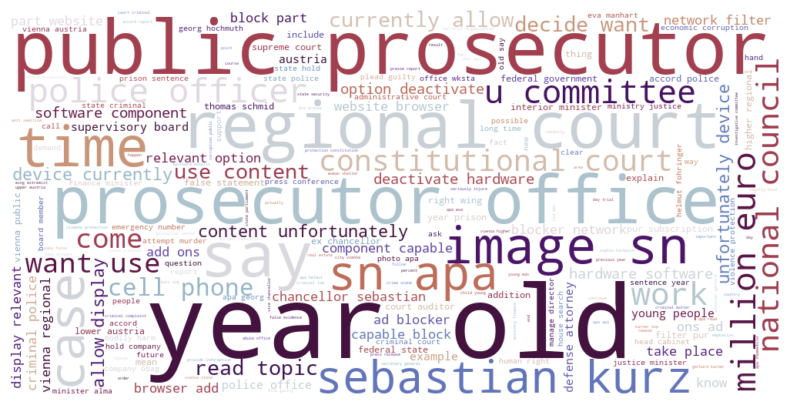

In [152]:
# Generating Word Cloud for Spoke Person: Daniel
wordcloud = WordCloud(width    = 1000, 
                      height   = 500, 
                      colormap = "twilight",
                      #   max_font_size = 72,
                      #   min_font_size = 5,
                      relative_scaling = 0.45,
                      background_color = "white").generate(" ".join(preproc_texts))

# Display the word cloud using matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

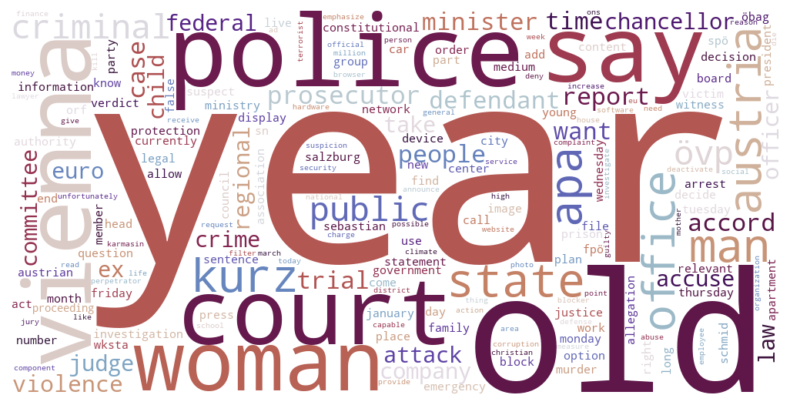

In [153]:
# Applying a TF-IDF process to weight words
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preproc_texts)
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).tolist()[0]))

# Generating Word Cloud for Spoke Person: Daniel
wordcloud = WordCloud(width    = 1000, 
                      height   = 500, 
                      colormap = "twilight",
                      #   max_font_size = 72,
                      #   min_font_size = 5,
                      relative_scaling = 0.45,
                      background_color = "white").generate_from_frequencies(tfidf_scores)

# Display the word cloud using matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##  Named Entity Recognition

In [154]:
def get_entities(text, nlp=nlp):
    NER_mod = nlp(text)
    entities = [str(ent) for ent in NER_mod.ents if ent.label_ not in ["DATE", "PRODUCT", "LANGUAGE", "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]]
    unique_tokens = list(dict.fromkeys(" ".join(entities).split()))
    return " ".join(unique_tokens)

In [155]:
entities_tot = [get_entities(article) for article in preproc_texts]

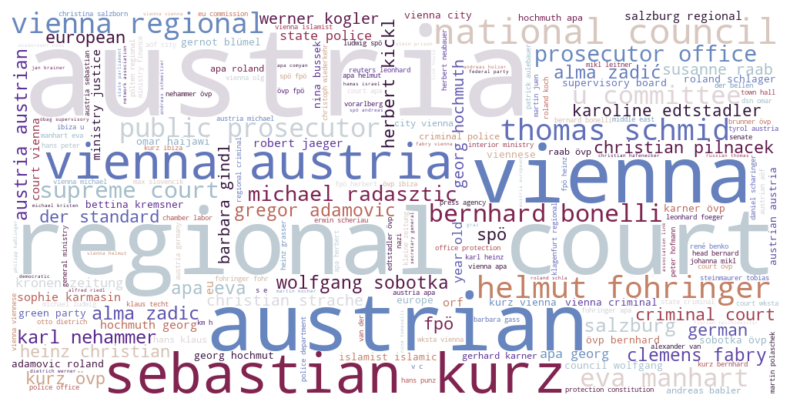

In [156]:
# Generating Word Cloud for Spoke Person: Daniel
wordcloud = WordCloud(width    = 1000, 
                      height   = 500, 
                      colormap = "twilight",
                      #   max_font_size = 72,
                      #   min_font_size = 5,
                      relative_scaling = 0.45,
                      background_color = "white").generate(" ".join(entities_tot))

# Display the word cloud using matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()